# Fickian Diffusion
One of the main applications of `OpenPNM` is simulating transport phenomena such as Fickian diffusion, advection diffusion, reactive transport, etc. In this example, we will learn how to perform Fickian diffusion on a `Cubic` network. The algorithm works fine with every other network type, but for now we want to keep it simple.

In [1]:
import numpy as np
import openpnm as op
%matplotlib inline
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

## Generating network
First, we need to generate a `Cubic` network. For now, we stick to a 2d network, but you might as well try it in 3d!

In [2]:
net = op.network.Cubic(shape=[1, 10, 10], spacing=1e-5)

## Adding geometry
Next, we need to add a geometry to the generated network. A geometry contains information about size of the pores/throats in a network. `OpenPNM` has tons of prebuilt geometries that represent the microstructure of different materials such as Toray090 carbon papers, sand stone, electrospun fibers, etc. For now, we stick to a sample geometry called `StickAndBall` that assigns random values to pore/throat diameters.

In [3]:
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

## Adding phase
Next, we need to add a phase to our simulation. A phase object(s) contain(s) thermophysical information about the working fluid(s) in the simulation. `OpenPNM` has tons of prebuilt phases as well! For this simulation, we use air as our working fluid.

In [4]:
air = op.phases.Air(network=net)

## Adding physics
Finally, we need to add a physics. A physics object contains information about the working fluid in the simulation that depend on the geometry of the network. A good example is diffusive conductance, which not only depends on the thermophysical properties of the working fluid, but also depends on the geometry of pores/throats.

In [5]:
phys_air = op.physics.Standard(network=net, phase=air, geometry=geom)

# Performing Fickian diffusion

Now that everything's set up, it's time to perform our Fickian diffusion simulation. For this purpose, we need to add the `FickianDiffusion` algorithm to our simulation. Here's how we do it:

In [6]:
fd = op.algorithms.FickianDiffusion(network=net, phase=air)

Note that `network` and `phase` are required parameters for pretty much every algorithm we add, since we need to specify on which network and for which phase do we want to run the algorithm.

## Adding boundary conditions
Next, we need to add some boundary conditions to the simulation. By default, `OpenPNM` assumes zero flux for the boundary pores.

In [7]:
inlet  = net.pores('left') 
outlet = net.pores('right')
fd.set_value_BC(pores=inlet, values=1.0)
fd.set_value_BC(pores=outlet, values=0.0)

`set_value_BC` applies the so-called "Dirichlet" boundary condition to the specified pores. Note that unless you want to apply a single value to all of the specified pores (like we just did), you must pass a list (or `ndarray`) as the `values` parameter.

## Running the algorithm
Now, it's time to run the algorithm. This is done by calling the `run` method attached to the algorithm object.

In [8]:
fd.run()

# Post processing
When an algorithm is successfully run, the results are attached to the same object. To access the results, you need to know the quantity for which the algorithm was solving. For instance, `FickianDiffusion` solves for the quantity `pore.concentration`, which is somewhat intuitive. However, if you ever forget it, or wanted to manually check the quantity, you can take a look at the algorithm `settings`:

In [9]:
print(fd.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
cache_A                             True
cache_b                             True
conductance                         throat.diffusive_conductance
phase                               phase_01
quantity                            pore.concentration
solver_atol                         None
solver_family                       scipy
solver_max_iter                     5000
solver_preconditioner               jacobi
solver_rtol                         None
solver_tol                          1e-08
solver_type                         spsolve
prefix                              alg
nlin_max_iter                       5000
relaxation_quantity                 1.0
relaxation_source                   1.0
sources                             []
variable_props                      []
――――――――――――――――――――

Now that we know the quantity for which `FickianDiffusion` was solved, let's take a look at the results:

In [10]:
c = fd['pore.concentration']
print(c)

[1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      0.91267 0.90187 0.90054 0.91128 0.91084 0.88996 0.87469 0.87716
 0.8507  0.84263 0.80921 0.80075 0.77933 0.82262 0.83891 0.81908 0.81563
 0.77664 0.80503 0.7953  0.71251 0.69485 0.70437 0.70722 0.70475 0.68911
 0.68715 0.66221 0.69181 0.73673 0.63355 0.63491 0.59695 0.60291 0.57963
 0.56686 0.57237 0.59206 0.5514  0.57784 0.50788 0.48281 0.44204 0.47417
 0.51511 0.51798 0.50987 0.49024 0.45262 0.42557 0.39318 0.35383 0.35696
 0.32933 0.37453 0.43335 0.37496 0.34393 0.32486 0.30223 0.24187 0.24826
 0.25028 0.25313 0.2222  0.24879 0.21113 0.21649 0.20653 0.20636 0.08496
 0.12765 0.14485 0.12433 0.11502 0.1134  0.10712 0.11482 0.1233  0.10319
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]


## Heatmap
Let's visualize the results. Since the network is 2d, we can simply reshape the results in form of a 2d array similar to the shape of the network and plot the heatmap of it using `matplotlib`.

In [11]:
print('Network shape:', net._shape)
c2d = c.reshape((net._shape))

Network shape: (1, 10, 10)


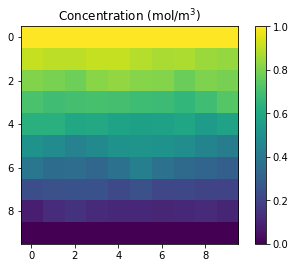

In [12]:
#NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
plt.imshow(c2d[0,:,:]);
plt.title('Concentration (mol/m$^3$)')
plt.colorbar()

## Calculating heat flux
You might as well be interested in calculating the mass flux from a boundary! This is easily done in `OpenPNM` via calling the `rate` method attached to the algorithm. Let's see how it works:

In [13]:
rate_inlet = fd.rate(pores=inlet)[0]
print(f'Mass flow rate from inlet: {rate_inlet:.5e} mol/s')

Mass flow rate from inlet: 6.70075e-12 mol/s
